## Import Libraries


In [5]:
from pyspark import SparkContext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

## Load data

In [6]:
df = pd.read_csv('games.csv')
df['season'] = df['season'].astype(int)
df['home_club_id'] = df['home_club_id'].astype(int)

## Filtering Data

In [7]:
df=df[df['competition_id'].isin(['L1', 'NL1', 'ES1', 'PO1', 'FR1', 'GB1', 'IT1', 'TR1'])]

## Data Preparation

In [8]:

home_club_goals = df.groupby(['home_club_id', 'season', 'competition_id']).agg(
    Total_Home_Club_Goals=('home_club_goals', 'sum'),
    Total_Away_Club_Goals=('away_club_goals', 'sum')
).reset_index()

away_club_goals = df.groupby(['away_club_id', 'season', 'competition_id']).agg(
    Total_Home_Club_Goals=('home_club_goals', 'sum'),
    Total_Away_Club_Goals=('away_club_goals', 'sum')
).reset_index()


merged_goals = pd.merge(home_club_goals, away_club_goals, left_on=['home_club_id', 'competition_id', 'season'], right_on=['away_club_id', 'competition_id', 'season'], how='outer').fillna(0)
merged_goals['club_id'] = merged_goals['home_club_id'].combine_first(merged_goals['away_club_id'])
merged_goals.drop(['home_club_id', 'away_club_id'], axis=1, inplace=True)

total_home_goals = merged_goals.groupby(['club_id','season', 'competition_id']).agg({'Total_Home_Club_Goals_x': 'sum', 'Total_Away_Club_Goals_y': 'sum'}).reset_index()
total_away_goals = merged_goals.groupby(['club_id','season', 'competition_id']).agg({'Total_Home_Club_Goals_y': 'sum', 'Total_Away_Club_Goals_x': 'sum'}).reset_index()


total_home_goals['GS'] = total_home_goals['Total_Home_Club_Goals_x'] + total_home_goals['Total_Away_Club_Goals_y']
total_home_goals.drop(['Total_Home_Club_Goals_x', 'Total_Away_Club_Goals_y'], axis=1, inplace=True)

total_away_goals['GC'] = total_away_goals['Total_Home_Club_Goals_y'] + total_away_goals['Total_Away_Club_Goals_x']
total_away_goals.drop(['Total_Home_Club_Goals_y', 'Total_Away_Club_Goals_x'], axis=1, inplace=True)

total_goals_info = pd.merge(total_home_goals , total_away_goals, on = ['club_id', 'competition_id', 'season'])
total_goals_info['club_id'] = total_goals_info['club_id'].astype(int)
total_goals_info['GC'] = total_goals_info['GC'].astype(int)
total_goals_info['GS'] = total_goals_info['GS'].astype(int)
total_goals_info['GD'] = total_goals_info['GS'] - total_goals_info['GC']

goals_for_home = df.groupby(['home_club_id', 'competition_id', 'season'])['home_club_goals'].agg(list).reset_index()
goals_against_home = df.groupby(['home_club_id', 'competition_id', 'season'])['away_club_goals'].agg(list).reset_index()

goals_against_away = df.groupby(['away_club_id', 'competition_id', 'season'])['home_club_goals'].agg(list).reset_index()
goals_for_away = df.groupby(['away_club_id', 'competition_id', 'season'])['away_club_goals'].agg(list).reset_index()

In [9]:
home_matches = pd.merge(goals_for_home, goals_against_home, left_on=['home_club_id', 'competition_id', 'season'], right_on=['home_club_id', 'competition_id', 'season'], how='outer').fillna(0)
away_matches = pd.merge(goals_against_away, goals_for_away, left_on=['away_club_id', 'competition_id', 'season'], right_on=['away_club_id', 'competition_id', 'season'], how='outer').fillna(0)

home_matches_key_value = [
    ((row['home_club_id'], row['competition_id'], row['season']),
    [row['home_club_goals'], row['away_club_goals']])
    for index, row in home_matches.iterrows()
]
away_matches_key_value = [
    ((row['away_club_id'], row['competition_id'], row['season']),
    [row['away_club_goals'], row['home_club_goals']])
    for index, row in away_matches.iterrows()
]

sc = SparkContext("local", "Soccer Stats")
rdd_home = sc.parallelize(home_matches_key_value)
rdd_away = sc.parallelize(away_matches_key_value)

def map_results(data):
    try:
        key , value = data
        club_id, competition_id, season = key[0], key[1], key[2]
        home_club_goals , away_club_goals = value[0] , value[1]
        results = list(map(lambda x, y: x - y, home_club_goals, away_club_goals))
        total_matches = len(results)
        wins = sum(1 for result in results if result > 0)
        losses = sum(1 for result in results if result < 0)
        draws = sum(1 for result in results if result == 0)
        return (club_id, competition_id, season), (total_matches, wins, losses, draws)
    except ValueError as e:
        print(f"Error with data: {data}")
        raise e

def reduce_results(a, b):
    total_matches_a, wins_a, losses_a, draws_a = a
    total_matches_b, wins_b, losses_b, draws_b = b
    return (total_matches_a + total_matches_b, wins_a + wins_b, losses_a + losses_b, draws_a + draws_b)

mapped_home = rdd_home.map(map_results)
mapped_away = rdd_away.map(map_results)

reduced_home = mapped_home.reduceByKey(reduce_results)
reduced_away = mapped_away.reduceByKey(reduce_results)

# Combining home and away results
final_results = reduced_home.union(reduced_away).reduceByKey(reduce_results)

# Collecting the results to the driver to see the output
results = final_results.collect()

# Populating dictionary after collecting results
team_win_lose = {}
for (key, value) in results:
    team_win_lose[key] = value

# Stopping Spark Context
sc.stop()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0) (LAPTOP-NS5CK02S executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Program Files\spark_unzipped\spark-3.5.1-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 10) than that in driver 3.9, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Program Files\spark_unzipped\spark-3.5.1-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 1100, in main
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 10) than that in driver 3.9, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [ ]:
sc.stop()

## Final club information

In [ ]:
club_id = []
season =  []
competition_id = []
matches_played = []
wins = []
draws = []
losses = []

for key, value in team_win_lose.items():
    club_id.append(key[0])
    competition_id.append(key[1])
    season.append(key[2])
    matches_played.append(value[0])
    wins.append(value[1])
    losses.append(value[2])
    draws.append(value[3])

new_df = pd.DataFrame({
    'club_id': club_id,
    'season': season,
    'competition_id': competition_id,
    'matches_played': matches_played,
    'wins': wins,
    'draws': draws,
    'losses': losses
})
final_club_information = pd.merge(total_goals_info, new_df, on = ['club_id','season', 'competition_id'])

## Adding label

In [ ]:
## Each element is array is a tuple (club_id , season)
champions = {
    "L1": [(27, 2012), (27, 2013), (27, 2014), (27, 2015), (27, 2016), (27, 2017), (27, 2018), (27, 2019), (27, 2020), (27, 2021)],
    "NL1": [(610, 2012), (610, 2013), (383, 2014), (383, 2015), (234, 2016), (383, 2017), (610, 2018), (610, 2019), (610, 2020), (610, 2021)],
    "ES1": [(714, 2012), (13, 2013), (714, 2014), (714, 2015), (418, 2016), (714, 2017), (714, 2018), (418, 2019), (13, 2020), (418, 2021)],
    "PO1": [(720, 2012), (294, 2013), (294, 2014), (294, 2015), (294, 2016), (720, 2017), (294, 2018), (720, 2019), (336, 2020), (720, 2021)],
    "FR1": [(583, 2012), (583, 2013), (583, 2014), (583, 2015), (162, 2016), (583, 2017), (583, 2018), (583, 2019), (1082, 2020), (583, 2021)],
    "GB1": [(985, 2012), (281, 2013), (631, 2014), (1003, 2015), (631, 2016), (281, 2017), (281, 2018), (31, 2019), (281, 2020), (281, 2021)],
    "IT1": [(506, 2012), (506, 2013), (506, 2014), (506, 2015), (506, 2016), (506, 2017), (506, 2018), (506, 2019), (46, 2020), (5, 2021)],
    "TR1": [(141, 2012), (36, 2013), (141, 2014), (114, 2015), (114, 2016), (141, 2017), (141, 2018), (6890, 2019), (114, 2020), (449, 2021)]
}
def is_champion(row):
    competition = row['competition_id']
    club_id = row['club_id']
    season = row['season']
    # Check if the competition is in the dictionary and if the (club_id, season) tuple is in the list for that competition
    if competition in champions and (club_id, season) in champions[competition]:
        return 1
    else:
        return 0

# Apply the function to each row
final_club_information['champion'] = final_club_information.apply(is_champion, axis=1)

print(final_club_information)

      club_id  season competition_id  GS  GC  GD  matches_played  wins  draws  \
0           3    2014             L1  34  40  -6              34     9     13   
1           3    2015             L1  38  42  -4              34    10     13   
2           3    2016             L1  51  42   9              34    12     13   
3           3    2017             L1  35  70 -35              34     5      7   
4           3    2019             L1  51  69 -18              34    10      6   
...       ...     ...            ...  ..  ..  ..             ...   ...    ...   
1672    68608    2013            PO1  19  33 -14              30     6     10   
1673    68608    2014            PO1  34  35  -1              34    12     12   
1674    68608    2015            PO1  44  66 -22              34    10     11   
1675    68608    2016            PO1  27  45 -18              34     9      9   
1676    68608    2017            PO1  33  46 -13              34     9     10   

      losses  champion  
0 

## Add Feature Engineering

In [ ]:
def Extract_Feature_Engineering(final_club_information):
    final_club_information['win_match_ratio'] = (final_club_information['wins'] + 1)/ final_club_information['matches_played']

    final_club_information['gs_match_ratio'] = (final_club_information['GS'] + 1)/ final_club_information['matches_played']

    final_club_information['gc_match_ratio'] = (final_club_information['GC'] + 1)/ final_club_information['matches_played']

    final_club_information['win_gs_ratio'] = (final_club_information['wins'] + 1)/(final_club_information['GS'] + 1)

    final_club_information['win_lost_ratio'] = (final_club_information['wins'] + 1)/(final_club_information['losses'] + 1)

    final_club_information['gs_gc'] = (final_club_information['GD']) + 0.1

    final_club_information['wins_draws_ratio'] = (final_club_information['wins'] +  1) / (final_club_information['draws'] + 1)

    final_club_information['gs_gd'] = (final_club_information['GS'] + 1) + (final_club_information['GD'])

Extract_Feature_Engineering(final_club_information)
print(final_club_information)


## Remove unwanted features


In [ ]:
x = final_club_information.drop(['season', 'competition_id','club_id','champion'], axis = 1, inplace = False)
y = final_club_information['champion']

      club_id  season competition_id  GS  GC  GD  matches_played  wins  draws  \
0           3    2014             L1  34  40  -6              34     9     13   
1           3    2015             L1  38  42  -4              34    10     13   
2           3    2016             L1  51  42   9              34    12     13   
3           3    2017             L1  35  70 -35              34     5      7   
4           3    2019             L1  51  69 -18              34    10      6   
...       ...     ...            ...  ..  ..  ..             ...   ...    ...   
1672    68608    2013            PO1  19  33 -14              30     6     10   
1673    68608    2014            PO1  34  35  -1              34    12     12   
1674    68608    2015            PO1  44  66 -22              34    10     11   
1675    68608    2016            PO1  27  45 -18              34     9      9   
1676    68608    2017            PO1  33  46 -13              34     9     10   

      losses  champion  win

## MI_SCORE


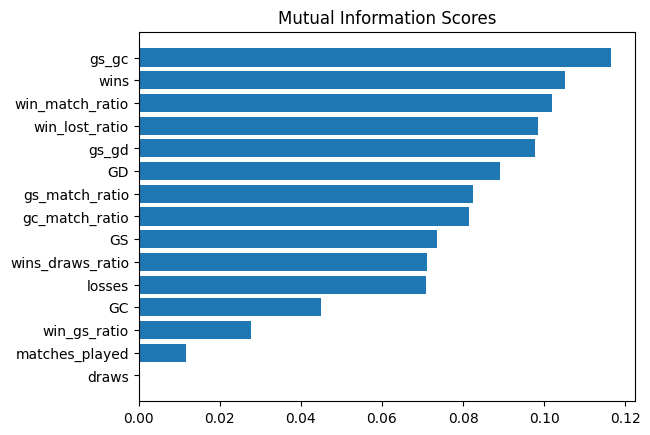

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_score=make_mi_scores(x,y)
plot_mi_scores(mi_score)

## Smote For Balancing Data

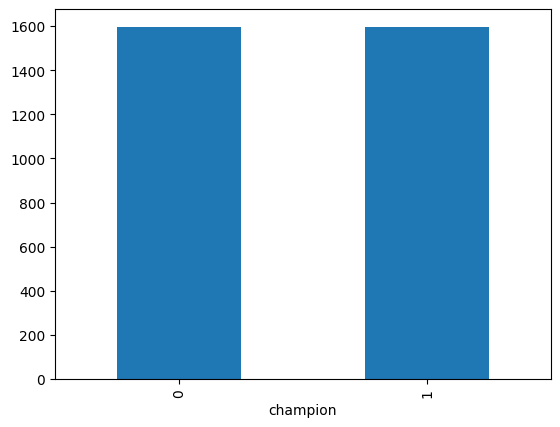

In [ ]:
smote = SMOTE()
x_sm, y_sm = smote.fit_resample(x, y)
pd.DataFrame(y_sm).champion.value_counts().plot(kind = 'bar')

## splitting into train and test set Percentage 75% to 25%


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_sm, y_sm,random_state = 42)

## Classification_Report

In [ ]:
def report(classifier, x_test=x_test, y_test=y_test):
    print("Classification Report: \n")
    y_preds = classifier.predict(x_test)
    print(classification_report(y_test, y_preds))

    print("Confusion Matrix: \n")
    # Calculate confusion matrix and then use ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print("ROC: \n")
    # Calculate ROC curve and then use RocCurveDisplay
    fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(x_test)[:, 1])
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_disp.plot()
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.show()


## Modeling

## Logistic_Regression

In [ ]:
log_clf = LogisticRegression(C=5.428675439323859,
                            penalty='l1',
                            solver='liblinear',
                            random_state=41)

param_grid = {
    'max_iter': [10, 50, 100, 150, 200]  # Adjust this list based on your needs and computational budget
}

grid_search = GridSearchCV(log_clf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best max_iter: ", grid_search.best_params_['max_iter'])
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best max_iter:  150
Best cross-validation score: 0.98


In [ ]:
log_clf = LogisticRegression(max_iter = 150,
                             C = 5.428675439323859,
                             penalty='l1',
                             solver='liblinear',
                             random_state = 41).fit(x_train, y_train)

cv_lr = cross_val_score(log_clf, x_train, y_train, cv = 10)
lr_score = np.mean(cv_lr)
print("LR Score: ", lr_score)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

LR Score:  0.977039748953975


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       410
           1       0.97      0.97      0.97       389

    accuracy                           0.97       799
   macro avg       0.97      0.97      0.97       799
weighted avg       0.97      0.97      0.97       799

Confusion Matrix: 



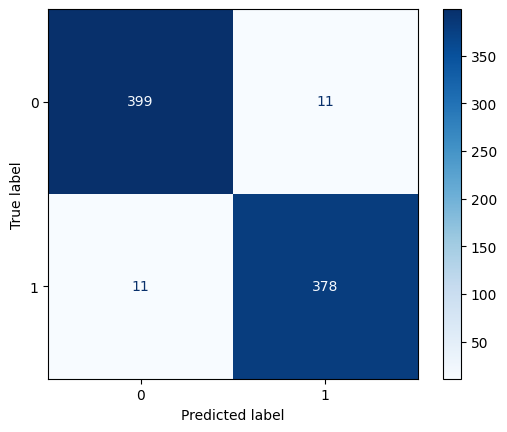

ROC: 



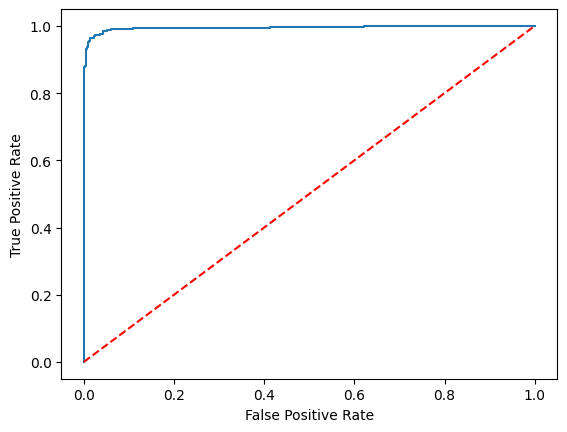

In [ ]:
report(log_clf)

## Create Single DataFrame

In [ ]:
def Create_Single_DataFrame(UserInput):
    data = {
        'club_id': [UserInput[0]],
        'season': [UserInput[1]],  # Assuming 'None' where the data is missing
        'competition_id': [UserInput[2]],
        'GS': [UserInput[3]],  # Goals Scored
        'GC': [UserInput[4]],  # Goals Conceded
        'GD': [UserInput[5]],  # Goal Difference
        'matches_played': [UserInput[6]],
        'wins': [UserInput[7]],  # Wins
        'draws': [UserInput[8]],  # Draws
        'losses': [UserInput[9]]  # Losses
    }

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

## Single Prediction



In [ ]:
UserInput=[31,2023,'GB1',72,29,43,30,23,4,3]

User_Input_Df=Create_Single_DataFrame(UserInput)

Extract_Feature_Engineering(User_Input_Df)
x = User_Input_Df.drop(['season', 'competition_id','club_id'], axis = 1, inplace = False)

print(log_clf.predict(x))

[1]


## Testing

In [ ]:
competition_id_value = 'GB1'  # Set your competition ID
season_id_value = 2012  # Set your season ID as an integer
filtered_df = final_club_information[(final_club_information['competition_id'] == competition_id_value) &
                (final_club_information['season'] == season_id_value)]

print(filtered_df)

In [ ]:
competition_id_value = 'ES1'  # Set your competition ID
season_id_value = 2018  # Set your season ID as an integer

filtered_df = final_club_information[(final_club_information['competition_id'] == competition_id_value) &
                (final_club_information['season'] == season_id_value)]
print(filtered_df)